This is an example of using the `XSPECInterface` class with *NuSTAR* solar data.
We go through fitting an isothermal model first without a pileup correction, then with a simulataneous pileup correction, and finally with a background (with pileup) that is then held fixed while the flare is fit.

This is not intended to be tutorial on how to use PyXSPEC.
For that, go to [their website](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html) and check out their examples.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pathlib
import zipfile

import matplotlib.pyplot as plt
import xspec

from pyxspec_extension.interface import XSPECInterface
from pyxspec_extension.plotter import ModelPlotter
from pyxspec_extension.config import DEFAULT_PARAMETER_FILE, DEFAULT_PILEUP_PARAMETER_FILE

# Set some variables used through the notebook

In [17]:
# Unzip the data archive.
with zipfile.ZipFile('./data.zip', 'r') as zipped:
    zipped.extractall('./')

abundance_file = '/home/reed/feld92a_coronal0.txt' # Change this to whatever you use
data_dir = pathlib.Path('./data/')
out_dir = pathlib.Path('./output/')

# Isothermal without pileup

## Initialize XSPEC

In [18]:
xspec.Xset.abund = f'file {abundance_file}'
interface = XSPECInterface()

## Read in the instrument data

Note that the PHA file contains the paths to the relevant response files, as per the OGIP standard.
This is necessary for PyXSPEC to find the `.srm` file associated with each PHA.

In [19]:
fpmA_pha = 'fpmA_flare_g0-4.pha'
fpmB_pha = 'fpmB_flare_g0-4.pha'
interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pha)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pha)
interface.read_data(data_dir)
xspec.AllData.ignore('bad') # Specify which energy channels to ignore.

Instrument: FPM A
	 {'signal_file': 'fpmA_flare_g0-4.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_flare_g0-4.pha', 'signal_data_group': 2, 'signal_source': 1}
	 {}
	 {}
1:1 fpmA_flare_g0-4.pha 2:2 fpmB_flare_g0-4.pha 


## Set the model component

The `add_component` method allows one to use either a model predefined by PyXSPEC or a custom model added by the user (see the PyXSPEC example on custom models for more info).

Here we choose the `vapec` multiplied by a constant to model to represent our data.
The constant allows for the fit to model the systematic offset between *NuSTAR*'s two telescopes. We also choose the parameter file to set our the intial values and limits of the parameters associated with the added component.

We also allow for the gain slope to be fitted.
This particular flare doesn't need a gain fit, but I wanted to demonstrate it here.
The following two examples will exclude the gain fit.

In [20]:
model_name = 'isothermal'
isothermal_model = interface.add_component(
    model_name = model_name,
    expression = 'const*vapec',
    parameter_limits_file = DEFAULT_PARAMETER_FILE,
    out_dir = out_dir)
slopes = {
    'FPM A': (1, 0.01, 0.94, 0.94, 1.0, 1.0), # Follows XSPEC's convention: (initial, delta, hard min, soft min, soft max, hard max)
    'FPM B': (1, 0.01, 0.94, 0.94, 1.0, 1.0)
}
offsets = {'A': 0, 'B': 0}
interface.set_gain(
    slopes = slopes, offsets = offsets,
    fit_slope = True, fit_offset = False)

Adding new component isothermal with expression const*vapec
Full expression is now constant*vapec
isothermal
parameter limits file: /home/reed/.pyenv/versions/3.13.3/envs/statistical/lib/python3.13/site-packages/pyxspec_extension/config/default.xconf
setting parameter limits for group 1 component vapec parameter kT (2)
(np.float64(0.25862068965517243), np.float64(0.008620689655172414), np.float64(0.1724137931034483), np.float64(0.1724137931034483), np.float64(2.586206896551724), np.float64(2.586206896551724))

setting parameter limits for group 1 component vapec parameter norm (17)
(np.float64(0.9955959999999999), np.float64(0.00995596), np.float64(0.0), np.float64(0.0), np.float64(9.95596e+19), np.float64(9.955959999999999e+23))

group_num = 2, and tie_data_groups = True, not setting limits for parameter kT
group_num = 2, and tie_data_groups = True, not setting limits for parameter norm
all_components: ['constant', 'vapec']
instrument.pileup_components_in_signal: {}
instrument.pileup_

## Fit the data to the model

One can also specify the stopping conditions for XSPEC.

In [21]:
interface.fit(
    num_iterations = 1000,
    critical_delta = 0.01,
    fit_statistic = 'cstat',
    fit_error = True # XSPEC will determine the error on all unfrozen parameters
)

error_str: isothermal:2 isothermal:17 isothermal:18 
result component names: ['vapec']
result component names: ['vapec']
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components


## Archive the fitted model for easy access of the parameters later.

Archiving the parameters essentially saves the state of the current model in the `XSPECInterface`'s `Archive` object.
If there are multiple stages to the fitting (e.g. fitting pileup then fitting the flare model), it allows one to take a snapshot of the parameters at any point in that process.
Note that this does not freeze the parameters of the archived model.

In [22]:
interface.archive_previous()
interface.archive.save(out_dir / f'{model_name}_archive.pkl')

result component names: ['vapec']
result component names: ['vapec']
newly_archived: OrderedDict({'FPM A': {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7dd344d61090>}, 'FPM B': {'signal': <pyxspec_extension.interface.ArchivedModel object at 0x7dd345baf820>}})
Archived model FPM A isothermal, expression constant*vapec
	Component constant
		Parameter factor
			Values: [1.0, -0.01, 0.0, 0.0, 10000000000.0, 10000000000.0]
			Frozen: True
	Component vapec
		Parameter kT
			Values: [0.6188012460618407, 0.006188012460618408, 0.1724137931034483, 0.1724137931034483, 2.586206896551724, 2.586206896551724]
			Frozen: False
		Parameter He
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter C
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter N
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter O
			Values: [1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
			Frozen: True
		Parameter Ne
			Values: [1.0, -0.01, 0

## Print the `Archive`

Let's look at the archive to see why it's useful.

In [23]:
archive = interface.archive
for name, instrument in (archive.instruments).items():
    print(f'Instrument: {name}')
    for model_name, model in instrument.items():
        print(f'\tModel: {model_name}')
        print(f'\tModel arrays: {model.arrays._fields}')
        for component_name, component in (model.components).items():
            print(f'\t\tComponent: {component_name}')
            for parameter_name, parameter in (component.parameters).items():
                print(f'\t\t\tParameter: {parameter_name}')
                print(f'\t\t\t\t{parameter.values}')
                print(f'\t\t\t\t{parameter.error}')

Instrument: FPM A
	Model: isothermal
	Model arrays: ('energy_edges', 'energy', 'energy_err', 'data', 'data_err', 'model', 'components')
		Component: constant
			Parameter: factor
				[1.0, -0.01, 0.0, 0.0, 10000000000.0, 10000000000.0]
				(0.0, 0.0, 'FFFFFFFFF')
		Component: vapec
			Parameter: kT
				[0.6188012460618407, 0.006188012460618408, 0.1724137931034483, 0.1724137931034483, 2.586206896551724, 2.586206896551724]
				(0.6147583374441874, 0.6224775849025898, 'FFFFFFFFF')
			Parameter: He
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: C
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: N
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: O
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: Ne
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFFFFFFF')
			Parameter: Mg
				[1.0, -0.01, 0.0, 0.0, 1000.0, 1000.0]
				(0.0, 0.0, 'FFFF

## Plot the results

The fit is pretty bad, and it's because there's no pileup correction.

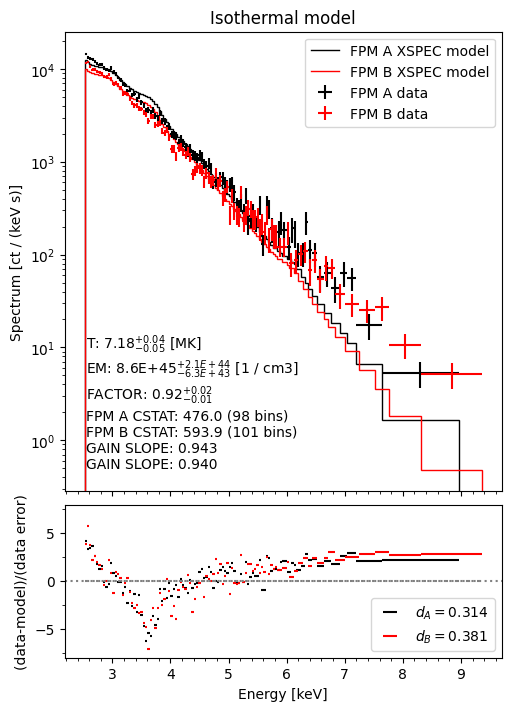

In [24]:
fig, axs = plt.subplots(
    2, 1, figsize=(5,7),
    sharex=True, layout='constrained',
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

plotter = ModelPlotter(archive)
ax0, ax1 = plotter.make_xspec_plot(model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()
plt.savefig(out_dir / f'{model_name}.png')

## Clear the data

This will remove the currently loaded data.

In [ ]:
interface.clear_data()

# Isothermal with pileup

This shows the previous example but with a pileup model fit simultaneous to the flare model.

**NOTE:** the response must be contained in a *single* file (i.e. a single `.srm` files rather than separate `.rmf` and `.arf` files) for this to work with PyXSPEC since we make use of the multiresponse attributes of PyXSPEC's `Spectrum` class, which only allows the specification of one response file.

## Initalize XSPEC

In [56]:
interface.clear_data()
xspec.Xset.abund = f'file {abundance_file}'
interface = XSPECInterface()

## Read data and configure model

Specifying both the signal file and pileup file at the same time indicates they will be fit simultaneously.

In [57]:
fpmA_pha = 'fpmA_flare_g0-4.pha'
fpmA_pileup = 'fpmA_flare_g21-24.pha'
fpmB_pha = 'fpmB_flare_g0-4.pha'
fpmB_pileup = 'fpmB_flare_g21-24.pha'

interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pha,
    pileup_file = fpmA_pileup)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pha,
    pileup_file = fpmB_pileup)
interface.read_data(data_dir)
xspec.AllData.ignore('bad') # Specify which energy channels to ignore.

pileup_models = interface.set_pileup_model('expmodgauss')
flare_model_name = 'isothermal_with_pileup'
model = interface.add_component(
    model_name = flare_model_name,
    expression = 'const*vapec',
    parameter_limits_file = DEFAULT_PILEUP_PARAMETER_FILE,
    out_dir = out_dir)

# Modify the pileup norm to accurately represent the grade 0-4 pileup (1.25x).
for instrument, pileup_model in zip(interface.instruments, pileup_models):
        pileup_component = pileup_model.componentNames[0]
        signal_model = interface.instruments[instrument].get_signal_model(
            flare_model_name)
        pileup_model_name = interface.instruments[instrument].pileup_model_name
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'

Instrument: FPM A
	 {'signal_file': 'fpmA_flare_g0-4.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {'pileup_file': 'fpmA_flare_g21-24.pha', 'pileup_data_group': 2, 'pileup_source': 2}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_flare_g0-4.pha', 'signal_data_group': 3, 'signal_source': 1}
	 {'pileup_file': 'fpmB_flare_g21-24.pha', 'pileup_data_group': 4, 'pileup_source': 3}
	 {}
1:1 fpmA_flare_g0-4.pha 2:2 fpmA_flare_g21-24.pha 3:3 fpmB_flare_g0-4.pha 4:4 fpmB_flare_g21-24.pha 
FPM A signal_spectrum.multiresponse[1] = "none"
FPM A signal_spectrum.multiresponse[2] = "none"
FPM A pileup_spectrum.multiresponse[0] = "none"
FPM A pileup_spectrum.multiresponse[1] = fpmA_flare_g21-24.srm
FPM A pileup_spectrum.multiresponse[2] = "none"
FPM B signal_spectrum.multiresponse[1] = "none"
FPM B signal_spectrum.multiresponse[2] = "none"
FPM B pileup_spectrum.multiresponse[0] = "none"
FPM B pileup_spectrum.multiresponse[1] = "none"
FPM B pileup_spectrum.multiresponse[2] = fpmB_flare_g21-24.srm

## Fit and save the model

In [58]:
interface.fit(critical_delta=0.1)
interface.archive_previous()
interface.archive.save(out_dir / f'{model_name}_archive.pkl')

error_str: isothermal_with_pileup:6 isothermal_with_pileup:21 pileupFPMA:1 pileupFPMA:2 pileupFPMA:3 pileupFPMA:4 isothermal_with_pileup:26 pileupFPMB:1 pileupFPMB:2 pileupFPMB:3 pileupFPMB:4 
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
result component names: ['expmodgauss']
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
result component names: ['expmodgauss']
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM A pileup result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B pileup result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: compon

## Print the archive

In [59]:
archive = interface.archive
for name, instrument in (archive.instruments).items():
    print(f'Instrument: {name}')
    for model_name, model in instrument.items():
        print(f'\tModel: {model_name}')
        print(f'\tModel arrays: {model.arrays._fields}')
        for component_name, component in (model.components).items():
            print(f'\t\tComponent: {component_name}')
            for parameter_name, parameter in (component.parameters).items():
                print(f'\t\t\tParameter: {parameter_name}')
                print(f'\t\t\t\t{parameter.values}')
                print(f'\t\t\t\t{parameter.error}')

Instrument: FPM A
	Model: pileupFPMA_isothermal_with_pileup
	Model arrays: ('energy_edges', 'energy', 'energy_err', 'data', 'data_err', 'model', 'components')
		Component: expmodgauss
			Parameter: lam
				[1.178355269577876, 0.01178355269577876, 0.1, 0.1, 5.0, 5.0]
				(1.0935382645665488, 1.3174344142646262, 'FFFFFFFFF')
			Parameter: mu
				[2.824610336836546, 0.02824610336836546, 2.5, 2.5, 10.0, 10.0]
				(2.5473636806335382, 2.976238818625159, 'FFFFFFFFF')
			Parameter: sigma
				[0.7080060762245116, 0.007080060762245116, 0.01, 0.01, 5.0, 5.0]
				(0.5443023915335177, 0.9509366380496179, 'FFFFFFFFF')
			Parameter: norm
				[0.2409539654116657, 0.002409539654116657, 0.0, 0.0, 1e+20, 1e+24]
				(0.2164638608857739, 0.28614108032109076, 'FFFFFFFFF')
	Model: isothermal_with_pileup
	Model arrays: ('energy_edges', 'energy', 'energy_err', 'data', 'data_err', 'model', 'components')
		Component: expmodgauss
			Parameter: lam
				[1.178355269577876, 0.01178355269577876, 0.1, 0.1, 5.0, 5.0]


## Plot the results

The fit is a lot better.

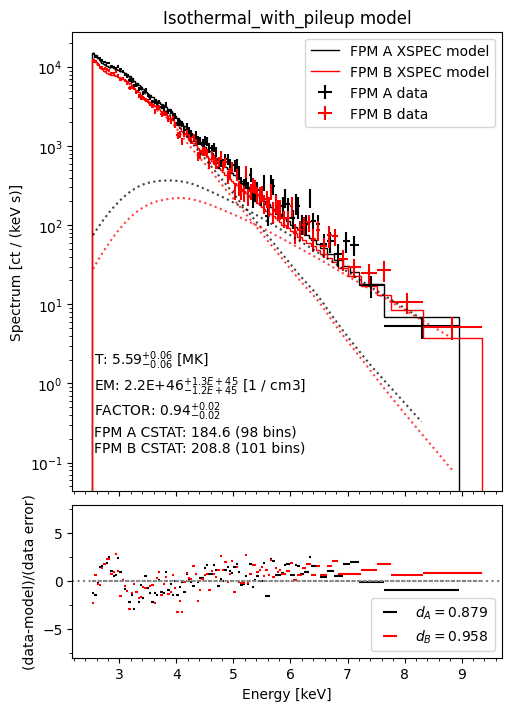

In [60]:
fig, axs = plt.subplots(
    2, 1, figsize=(5,7),
    sharex=True, layout='constrained',
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

plotter = ModelPlotter(interface.archive)
ax0, ax1 = plotter.make_xspec_plot(flare_model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()
plt.savefig(out_dir / f'{flare_model_name}.png')

# Isothermal with pileup and fixed background

Now, we will fit a background (with its own pileup model) that is then held fixed while the flare (with its pileup model) is fitted.

## Configure background model (isothermal with pileup)

In [45]:
interface.clear_data()
xspec.Xset.abund = f'file {abundance_file}'
interface = XSPECInterface()

background_fpmA_pha = 'fpmA_background_g0-4.pha'
background_fpmA_pileup = 'fpmA_background_g21-24.pha'
background_fpmB_pha = 'fpmB_background_g0-4.pha'
background_fpmB_pileup = 'fpmB_background_g21-24.pha'

interface.add_instrument(
    name = 'FPM A',
    signal_file = background_fpmA_pha,
    pileup_file = background_fpmA_pileup)
interface.add_instrument(
    name = 'FPM B',
    signal_file = background_fpmB_pha,
    pileup_file = background_fpmB_pileup)
interface.read_data(data_dir)
xspec.AllData.ignore('bad') # Specify which energy channels to ignore.

pileup_models = interface.set_pileup_model('expmodgauss')
background_model_name = 'background'
model = interface.add_component(
    model_name = background_model_name,
    expression = 'const*vapec',
    parameter_limits_file = DEFAULT_PILEUP_PARAMETER_FILE,
    freeze_previous=True,
    out_dir = out_dir)

# Modify the pileup norm to accurately represent the grade 0-4 pileup (1.25x).
for instrument, pileup_model in zip(interface.instruments, pileup_models):
        pileup_component = pileup_model.componentNames[0]
        signal_model = interface.instruments[instrument].get_signal_model(
            background_model_name)
        pileup_model_name = interface.instruments[instrument].pileup_model_name
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'

Instrument: FPM A
	 {'signal_file': 'fpmA_background_g0-4.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {'pileup_file': 'fpmA_background_g21-24.pha', 'pileup_data_group': 2, 'pileup_source': 2}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_background_g0-4.pha', 'signal_data_group': 3, 'signal_source': 1}
	 {'pileup_file': 'fpmB_background_g21-24.pha', 'pileup_data_group': 4, 'pileup_source': 3}
	 {}
1:1 fpmA_background_g0-4.pha 2:2 fpmA_background_g21-24.pha 3:3 fpmB_background_g0-4.pha 4:4 fpmB_background_g21-24.pha 
FPM A signal_spectrum.multiresponse[1] = "none"
FPM A signal_spectrum.multiresponse[2] = "none"
FPM A pileup_spectrum.multiresponse[0] = "none"
FPM A pileup_spectrum.multiresponse[1] = fpmA_background_g21-24.srm
FPM A pileup_spectrum.multiresponse[2] = "none"
FPM B signal_spectrum.multiresponse[1] = "none"
FPM B signal_spectrum.multiresponse[2] = "none"
FPM B pileup_spectrum.multiresponse[0] = "none"
FPM B pileup_spectrum.multiresponse[1] = "none"
FPM B pileup_spec

## Fit background

In [46]:
interface.fit()
interface.archive_previous()
interface.clear_data()
interface.archive.save(out_dir / f'{background_model_name}_archive.pkl')

error_str: background:6 background:21 pileupFPMA:1 pileupFPMA:2 pileupFPMA:3 pileupFPMA:4 background:26 pileupFPMB:1 pileupFPMB:2 pileupFPMB:3 pileupFPMB:4 
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
result component names: ['expmodgauss']
result component names: ['expmodgauss', 'vapec']
adding component to result: expmodgauss
adding component to result: vapec
result component names: ['expmodgauss']
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM A pileup result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM B pileup result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
result component names: ['expmo

## Plot background

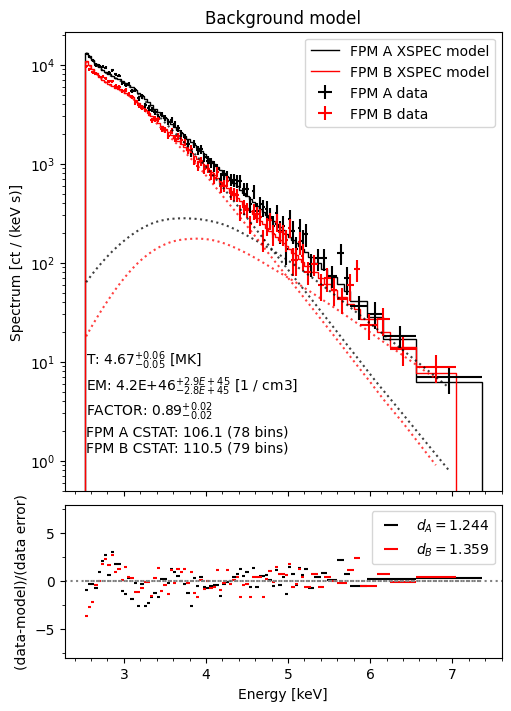

In [47]:
fig, axs = plt.subplots(
    2, 1, figsize=(5,7),
    sharex=True, layout='constrained',
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

plotter = ModelPlotter(interface.archive)
ax0, ax1 = plotter.make_xspec_plot(background_model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()
plt.savefig(out_dir / f'{background_model_name}.png')

## Configure flare model

This is basically the same as before.
Note that we set `freeze_previous=True` in the `add_component` call.
This freezes the background model (including its pileup component) while the flare model is fit.

In [48]:
fpmA_pha = 'fpmA_flare_g0-4.pha'
fpmA_pileup = 'fpmA_flare_g21-24.pha'
fpmB_pha = 'fpmB_flare_g0-4.pha'
fpmB_pileup = 'fpmB_flare_g21-24.pha'

interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pha,
    pileup_file = fpmA_pileup)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pha,
    pileup_file = fpmB_pileup)
interface.read_data(data_dir)
xspec.AllData.ignore('bad') # Specify which energy channels to ignore.

pileup_models = interface.set_pileup_model('expmodgauss')
flare_model_name = 'isothermal_with_pileup_and_background'
model = interface.add_component(
    model_name = flare_model_name,
    expression = 'const*vapec',
    parameter_limits_file = DEFAULT_PILEUP_PARAMETER_FILE,
    freeze_previous=True,
    out_dir = out_dir)

# Modify the pileup norm to accurately represent the grade 0-4 pileup (1.25x).
for instrument, pileup_model in zip(interface.instruments, pileup_models):
        pileup_component = pileup_model.componentNames[0]
        signal_model = interface.instruments[instrument].get_signal_model(
            flare_model_name)
        pileup_model_name = interface.instruments[instrument].pileup_model_name
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'

Instrument: FPM A
	 {'signal_file': 'fpmA_flare_g0-4.pha', 'signal_data_group': 1, 'signal_source': 1}
	 {'pileup_file': 'fpmA_flare_g21-24.pha', 'pileup_data_group': 2, 'pileup_source': 2}
	 {}
Instrument: FPM B
	 {'signal_file': 'fpmB_flare_g0-4.pha', 'signal_data_group': 3, 'signal_source': 1}
	 {'pileup_file': 'fpmB_flare_g21-24.pha', 'pileup_data_group': 4, 'pileup_source': 3}
	 {}
1:1 fpmA_flare_g0-4.pha 2:2 fpmA_flare_g21-24.pha 3:3 fpmB_flare_g0-4.pha 4:4 fpmB_flare_g21-24.pha 
FPM A signal_spectrum.multiresponse[1] = "none"
FPM A signal_spectrum.multiresponse[2] = "none"
FPM A pileup_spectrum.multiresponse[0] = "none"
FPM A pileup_spectrum.multiresponse[1] = fpmA_flare_g21-24.srm
FPM A pileup_spectrum.multiresponse[2] = "none"
FPM B signal_spectrum.multiresponse[1] = "none"
FPM B signal_spectrum.multiresponse[2] = "none"
FPM B pileup_spectrum.multiresponse[0] = "none"
FPM B pileup_spectrum.multiresponse[1] = "none"
FPM B pileup_spectrum.multiresponse[2] = fpmB_flare_g21-24.srm

## Fit flare model

In [49]:
interface.fit()
interface.archive_previous()
interface.clear_data()
interface.archive.save(out_dir / f'{flare_model_name}_archive.pkl')

error_str: isothermal_with_pileup_and_background:27 isothermal_with_pileup_and_background:42 pileupFPMA:1 pileupFPMA:2 pileupFPMA:3 pileupFPMA:4 isothermal_with_pileup_and_background:68 pileupFPMB:1 pileupFPMB:2 pileupFPMB:3 pileupFPMB:4 
result component names: ['expmodgauss', 'vapec', 'expmodgauss_4', 'vapec_6']
adding component to result: expmodgauss
adding component to result: vapec
adding component to result: expmodgauss_4
adding component to result: vapec_6
result component names: ['expmodgauss']
result component names: ['expmodgauss', 'vapec', 'expmodgauss_4', 'vapec_6']
adding component to result: expmodgauss
adding component to result: vapec
adding component to result: expmodgauss_4
adding component to result: vapec_6
result component names: ['expmodgauss']
FPM A result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: model
	Key: components
FPM A pileup result:
	Key: energy_edges
	Key: energy
	Key: energy_err
	Key: data
	Key: data_err
	Key: mod

## Plot flare

What a mess of model components!

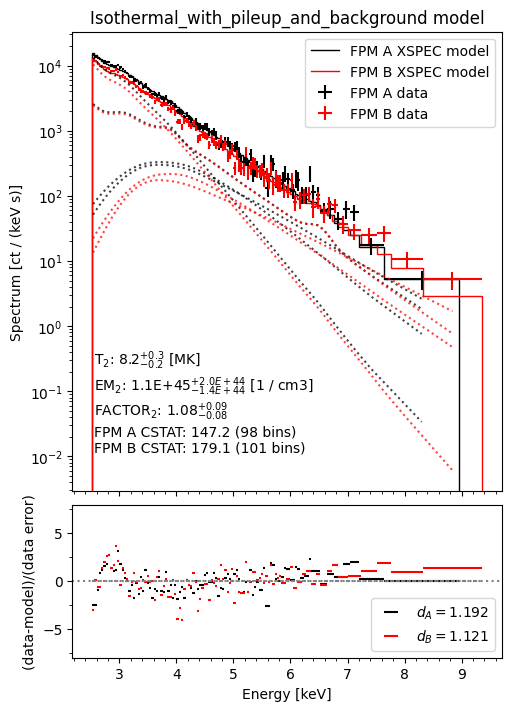

In [50]:
fig, axs = plt.subplots(
    2, 1, figsize=(5,7),
    sharex=True, layout='constrained',
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

plotter = ModelPlotter(interface.archive)
ax0, ax1 = plotter.make_xspec_plot(flare_model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()
plt.savefig(out_dir / f'{flare_model_name}.png')